# Infiniti Q50 Sales Forecasting
![title](assets/q50_image.jpg)

## Problem Statement
As 2024 comes to a close, Nissan Motor Corporation's bankruptcy has left many questioning the decisions leading to its downfall. Among these decisions is the discontinuation of the Infiniti Q50 sedan, Nissan’s luxury brand offering, at the end of this year. The Q50, once a foundation of the Infiniti lineup, has struggled to maintain competitive sales among changing consumer preferences and economic pressures. Retrospective analysis of this years sales reveals that discontinuing the Q50 earlier might have been in the company's best financial interest.

This analysis focuses on the Infiniti Q50's sales data to address two critical questions: How accurately can we forecast its sales performance for the first six months of 2024? and What insights can we derive from this forecasting exercise to inform future decision-making? By employing machine learning and time-series forecasting procedures, we aim to demonstrate the predictive capabilities of modern algorithms.

We analyze the performance of four forecasting methods: Lasso Regression, Random Forest, Boosting (XGBoost), and Facebook's Prophet model. Each model is explored in depth, covering its mechanics, application to this specific task, hyperparameter tuning process, and performance evaluation. This study not only serves as an exercise in predictive analytics but also provides valuable lessons for automakers navigating uncertain market dynamics.


## Reading in the data

#### Firstly we will load in data from all of our different sources, and ensure uniformity between them

## Q50 Sales Data

The Q50 sales data was parsed into csv format using computer vision from the table on the website below. Aditionally, we must reomve any 0 data. The time window avaliable for this data is the bottleneck for the other data. We will also reshape the data accordingly and add a date label

https://www.goodcarbadcar.net/infiniti-q50-sales-figures-usa-canada/


In [5]:
import pandas as pd

In [6]:
q50_sales_df = pd.read_csv("data/q50_sales_data.csv", header = None) # Couldn't initially read in as int

# Reshaped to one column
q50_sales_df = q50_sales_df.stack().reset_index(drop = True).to_frame(name = "Units Sold")

# Removed commas and changed datatype to int
q50_sales_df["Units Sold"] = q50_sales_df["Units Sold"].str.replace(",", "").astype(int)

# Removed leading and trailing 0's (pre sale 2013, and remaining 2024 months)
q50_sales_df = q50_sales_df[q50_sales_df["Units Sold"] != 0].reset_index(drop=True)

dates = pd.date_range(start="2013-08-01", end="2024-08-01", freq="MS")
q50_sales_df.insert(0, "Date", dates)
q50_sales_df

,Date,Units Sold
0,2013-08-01,2434
1,2013-09-01,2367
2,2013-10-01,2556
3,2013-11-01,5891
4,2013-12-01,4568
...,...,...
128,2024-04-01,468
129,2024-05-01,487
130,2024-06-01,487
131,2024-07-01,427


## Q50 Google Search Data
This data ranges from 0 to 100, and represents the search popularity of the "Infiniti Q50" search term on Google

https://trends.google.com/trends/explore?date=2013-08-01%202024-09-01&geo=US&q=infiniti%20q50&hl=en

In [8]:
name = ["Search Score"]
search_df = pd.read_csv("data/search.csv", header = None, dtype = int, names = name)
search_df

,Search Score
0,98
1,76
2,58
3,57
4,54
...,...
128,83
129,88
130,94
131,96


## Gasoline Average Price
Price of gasoline (unleaded) on average in the US

https://fred.stlouisfed.org/series/APU000074714

In [10]:
name = ["Gasoline Price"]
gasoline_df = pd.read_csv("data/gasoline.csv", header = None, dtype = float, names = name)
gasoline_df

,Gasoline Price
0,3.600
1,3.556
2,3.375
3,3.251
4,3.277
...,...
128,3.776
129,3.755
130,3.601
131,3.622


## Auto Loan Interest Rates
Interest rates for 60-month auto loan period

08/13 - 11/13 from https://fred.stlouisfed.org/series/RIFLPBCIANM60NM

12/13 from https://www.experianplc.com/newsroom/press-releases/2013/experian-automotive-interest-rates-for-auto-loans-hit-all-time-low#:~:text=Schaumburg%2C%20Ill.%2C%20Dec.,reporting%20the%20data%20in%202008.


01/14 - 08/24 from https://www.statista.com/statistics/290673/auto-loan-rates-usa/ (Excluding 12/23)

In [12]:
name = ["Interest Rate"]
interest_df = pd.read_csv("data/interest.csv", header = None, dtype = float, names = name)
interest_df

,Interest Rate
0,4.38
1,4.43
2,4.48
3,4.52
4,4.27
...,...
128,7.82
129,7.86
130,7.92
131,7.89


## Unemployment Rate

Unemployment rate in the US

https://fred.stlouisfed.org/series/UNRATENSA

In [14]:
name = ["Unemployment Rate"]
unemployment_df = pd.read_csv("data/unemployment.csv", header = None, dtype = float, names = name)
unemployment_df

,Unemployment Rate
0,7.3
1,7.0
2,7.0
3,6.6
4,6.5
...,...
128,3.5
129,3.7
130,4.3
131,4.5


## Producer Price Index: Men's Underwear

A seemingly odd indicator of economic strength, where men buy less underwear in scarce times (lower PPI)

https://fred.stlouisfed.org/series/WPUSI094011

In [16]:
name = ["PPI: Men's Underwear"]
mens_df = pd.read_csv("data/mens_underwear.csv", header = None, dtype = float, names = name)
mens_df

,PPI: Men's Underwear
0,147.400
1,147.400
2,147.400
3,147.500
4,147.500
...,...
128,159.977
129,159.977
130,159.977
131,159.977


## Producer Price Index: Average Rent of Primary Residence

Average rent price of primary homes in the US

https://fred.stlouisfed.org/series/CUUR0000SEHA

In [18]:
name = ["Average Rent"]
rent_df = pd.read_csv("data/rent.csv", header = None, dtype = float, names = name)
rent_df

,Average Rent
0,268.505
1,269.137
2,269.960
3,270.698
4,271.688
...,...
128,416.386
129,417.772
130,418.820
131,420.577


## Consumer Price Index

Measure of inflation in the US

https://fred.stlouisfed.org/series/CPIAUCSL

In [20]:
name = ["CPI"]
cpi_df = pd.read_csv("data/cpi.csv", header = None, dtype = float, names = name)
cpi_df

,CPI
0,233.456
1,233.544
2,233.669
3,234.100
4,234.719
...,...
128,313.207
129,313.225
130,313.049
131,313.534


## Aggregating the tables

In [22]:
all_data = pd.concat(
    [q50_sales_df, search_df, gasoline_df, interest_df, unemployment_df, mens_df, rent_df, cpi_df],
    axis=1
)
all_data = all_data.dropna().reset_index(drop=True)
all_data

,Date,Units Sold,Search Score,Gasoline Price,Interest Rate,Unemployment Rate,PPI: Men's Underwear,Average Rent,CPI
0,2013-08-01,2434,98,3.600,4.38,7.3,147.400,268.505,233.456
1,2013-09-01,2367,76,3.556,4.43,7.0,147.400,269.137,233.544
2,2013-10-01,2556,58,3.375,4.48,7.0,147.400,269.960,233.669
3,2013-11-01,5891,57,3.251,4.52,6.6,147.500,270.698,234.100
4,2013-12-01,4568,54,3.277,4.27,6.5,147.500,271.688,234.719
...,...,...,...,...,...,...,...,...,...
128,2024-04-01,468,83,3.776,7.82,3.5,159.977,416.386,313.207
129,2024-05-01,487,88,3.755,7.86,3.7,159.977,417.772,313.225
130,2024-06-01,487,94,3.601,7.92,4.3,159.977,418.820,313.049
131,2024-07-01,427,96,3.622,7.89,4.5,159.977,420.577,313.534


## Lagged Data
For our 3 ML models, in order to make a practical model, we should use data from previous months as covariates. To do this, for each row, we will shift every column to the right of units sold, to a row that is 5 months after. Along with this, we will add a column that showed the units sold 5 months ago. This will remove alot of 2013 data, which will be dropped. The row will effectively have, a date, the units sold on that date, units sold 5 months ago, and all other statistics/economic data from 5 months ago. This means that this model could have been used to predict the rest of 2024 sales from January 2024, as we would have had all of the neccessary information

In [24]:
all_data["Units Sold 5 Months Ago"] = all_data["Units Sold"]

# Shift all other covariates (except Date and "Units Sold")
covariates = all_data.columns.difference(["Date", "Units Sold"])
all_data[covariates] = all_data[covariates].shift(5) # Chose 5 because 6 increased the MAPE/RMSE by a marginally significant amount

# Drop rows with NaN values resulting from lagging (this will remove alot of 2013 data)
all_data_lagged = all_data.dropna().reset_index(drop=True)
all_data_lagged

,Date,Units Sold,Search Score,Gasoline Price,Interest Rate,Unemployment Rate,PPI: Men's Underwear,Average Rent,CPI,Units Sold 5 Months Ago
0,2014-01-01,2949,98.0,3.600,4.38,7.3,147.400,268.505,233.456,2434.0
1,2014-02-01,3275,76.0,3.556,4.43,7.0,147.400,269.137,233.544,2367.0
2,2014-03-01,3795,58.0,3.375,4.48,7.0,147.400,269.960,233.669,2556.0
3,2014-04-01,2626,57.0,3.251,4.52,6.6,147.500,270.698,234.100,5891.0
4,2014-05-01,2938,54.0,3.277,4.27,6.5,147.500,271.688,234.719,4568.0
...,...,...,...,...,...,...,...,...,...,...
123,2024-04-01,468,85.0,3.500,7.70,3.5,159.830,408.838,308.024,388.0
124,2024-05-01,487,78.0,3.289,7.72,3.5,159.830,410.606,308.742,403.0
125,2024-06-01,487,81.0,3.221,7.75,4.1,159.830,412.019,309.685,460.0
126,2024-07-01,427,87.0,3.359,7.91,4.2,159.830,413.695,311.054,460.0


## Train Test Split

In [26]:
# Seperating X and Y into just response (Y/units sold) and explanatory (X/all the covariates)
X = all_data_lagged.drop(columns=["Units Sold"])
y = all_data_lagged["Units Sold"]

# Training and testing split
train_idx = (all_data_lagged["Date"] < "2024-01-01")
test_idx = (all_data_lagged["Date"] >= "2024-01-01") & (all_data_lagged["Date"] <= "2024-06-01") # 6 predictions
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Drop the date column (model will throw error)
X_train = X_train.drop(columns=["Date"])
X_test = X_test.drop(columns=["Date"])

## Imports for ML Algorithms

In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

## Lasso & CV Parameter tuning

In [31]:
# Normalize values to prevent unnecessary penalization by Lasso
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the range of alphas to test from 0.0001 to 10
alpha_values = np.logspace(-4, 1, 50)  

# Store MAPE for each alpha so we can find the best one later
mape_scores = []

# Instead of using LassoCV which creates folds on train data,
# We'll manually iterate through alpha values and validates
# on our test data
for alpha in alpha_values:
    # Train Lasso model
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    
    # Predict on test data
    y_pred_test = lasso.predict(X_test_scaled)
    
    # Calculate MAPE from predictions
    mape = mean_absolute_percentage_error(y_test, y_pred_test)
    mape_scores.append(mape)

# Find the alpha with the lowest MAPE
best_alpha = alpha_values[np.argmin(mape_scores)]
best_mape = min(mape_scores)

# Train the final model using the best alpha
final_lasso = Lasso(alpha=best_alpha, max_iter=10000)
final_lasso.fit(X_train_scaled, y_train)
final_y_pred = final_lasso.predict(X_test_scaled)

# Show which coefficients Lasso chose
lasso_coefficients = final_lasso.coef_
non_zero_features = [feature for feature, coef in zip(X_train.columns, lasso_coefficients) if coef != 0]
print("Covariates chosen by Lasso:")
print(non_zero_features)
print(f"Best Alpha: {best_alpha}")
print(f"Best MAPE: {best_mape}")

Covariates chosen by Lasso:
['Search Score', 'Gasoline Price', 'Interest Rate', 'Unemployment Rate', 'Average Rent', 'Units Sold 5 Months Ago']
Best Alpha: 4.941713361323838
Best MAPE: 0.22631295454275072


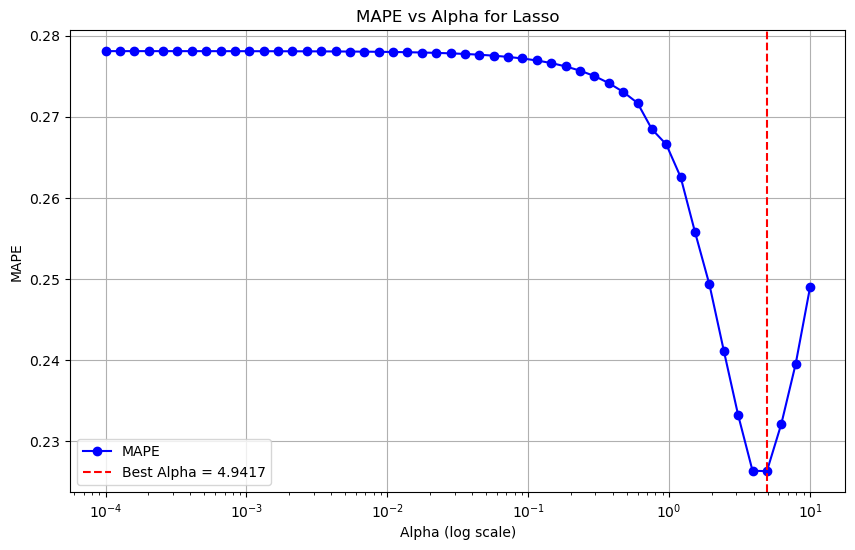

In [32]:
# Plot MAPE vs Alpha
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, mape_scores, marker='o', linestyle='-', color='b', label="MAPE")
plt.axvline(best_alpha, color='r', linestyle='--', label=f"Best Alpha = {best_alpha:.4f}")
plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("MAPE")
plt.title("MAPE vs Alpha for Lasso")
plt.legend()
plt.grid(True)
plt.show()

## Correlation Matrix

In [34]:
import seaborn as sns

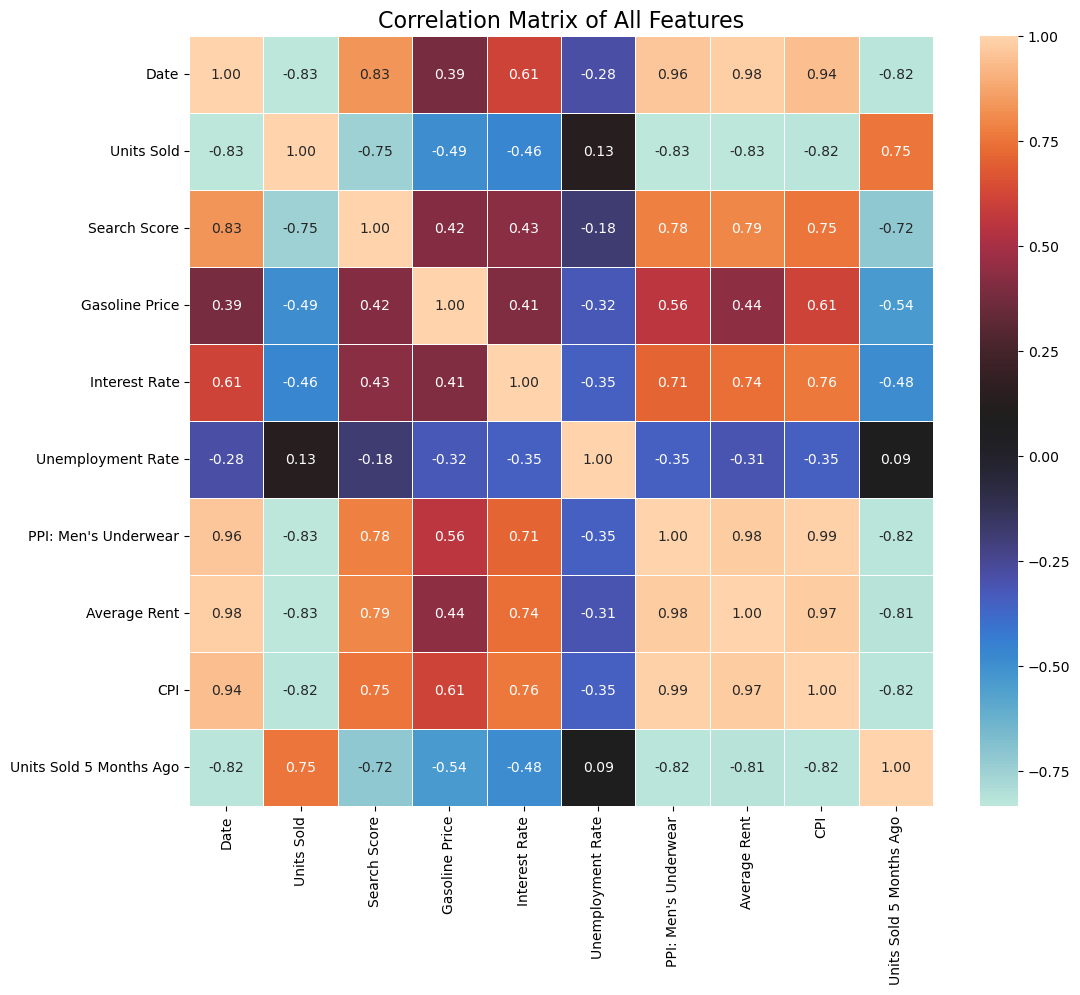

In [35]:
correlation_matrix = all_data.corr()

plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True, 
    fmt=".2f",   
    cmap="icefire", 
    linewidths=0.5    
)

# Add title
plt.title("Correlation Matrix of All Features", fontsize=16)

# Show the plot
plt.show()

## Random Forest

In [37]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

## XGBoost

In [39]:
xgb_model = xgb.XGBRegressor(tree_method = "hist", n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

## Error Metrics

#### Mean Absolute Percentage Error (MAPE)
$$
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100
$$

#### Mean Absolute Error (MAE)
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

#### Root Mean Squared Error (RMSE)
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}
$$

Where:
- \( y_i \) is the actual value.
- \( \hat{y}_i \) is the predicted value.
- \( n \) is the number of observations.


In [41]:
for model_name, y_pred in zip(
    ["Lasso", "Random Forest", "XGBoost"], 
    [final_y_pred, y_pred_rf, y_pred_xgb]
):
    print(f"{model_name} Results:")
    print(f"  MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"  RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_test, y_pred):.2f}")
    print()

results_df = pd.DataFrame({
    "ds": all_data_lagged["Date"].iloc[120:126].values,  
    "Actual": y_test,       
    "Lasso": final_y_pred,   
    "Random Forest": y_pred_rf,  
    "XGBoost": y_pred_xgb  
})

results_df

Lasso Results:
  MAE: 105.78
  RMSE: 133.78
  MAPE: 0.23

Random Forest Results:
  MAE: 55.47
  RMSE: 63.22
  MAPE: 0.12

XGBoost Results:
  MAE: 77.73
  RMSE: 84.75
  MAPE: 0.16



,ds,Actual,Lasso,Random Forest,XGBoost
120,2024-01-01,460,237.525791,373.64,416.469330
121,2024-02-01,460,268.972379,434.32,409.489716
122,2024-03-01,478,352.728048,486.71,420.990967
123,2024-04-01,468,468.138898,515.69,535.731140
124,2024-05-01,487,558.612112,570.82,601.937256
125,2024-06-01,487,462.873414,567.53,619.684326


## Visualizing Trends in Data
Before fitting the time series with the Prophet model, Lets revisit the data to see if we can find any trends in the data that can help us decide what the tuning parameters should look like for our next model

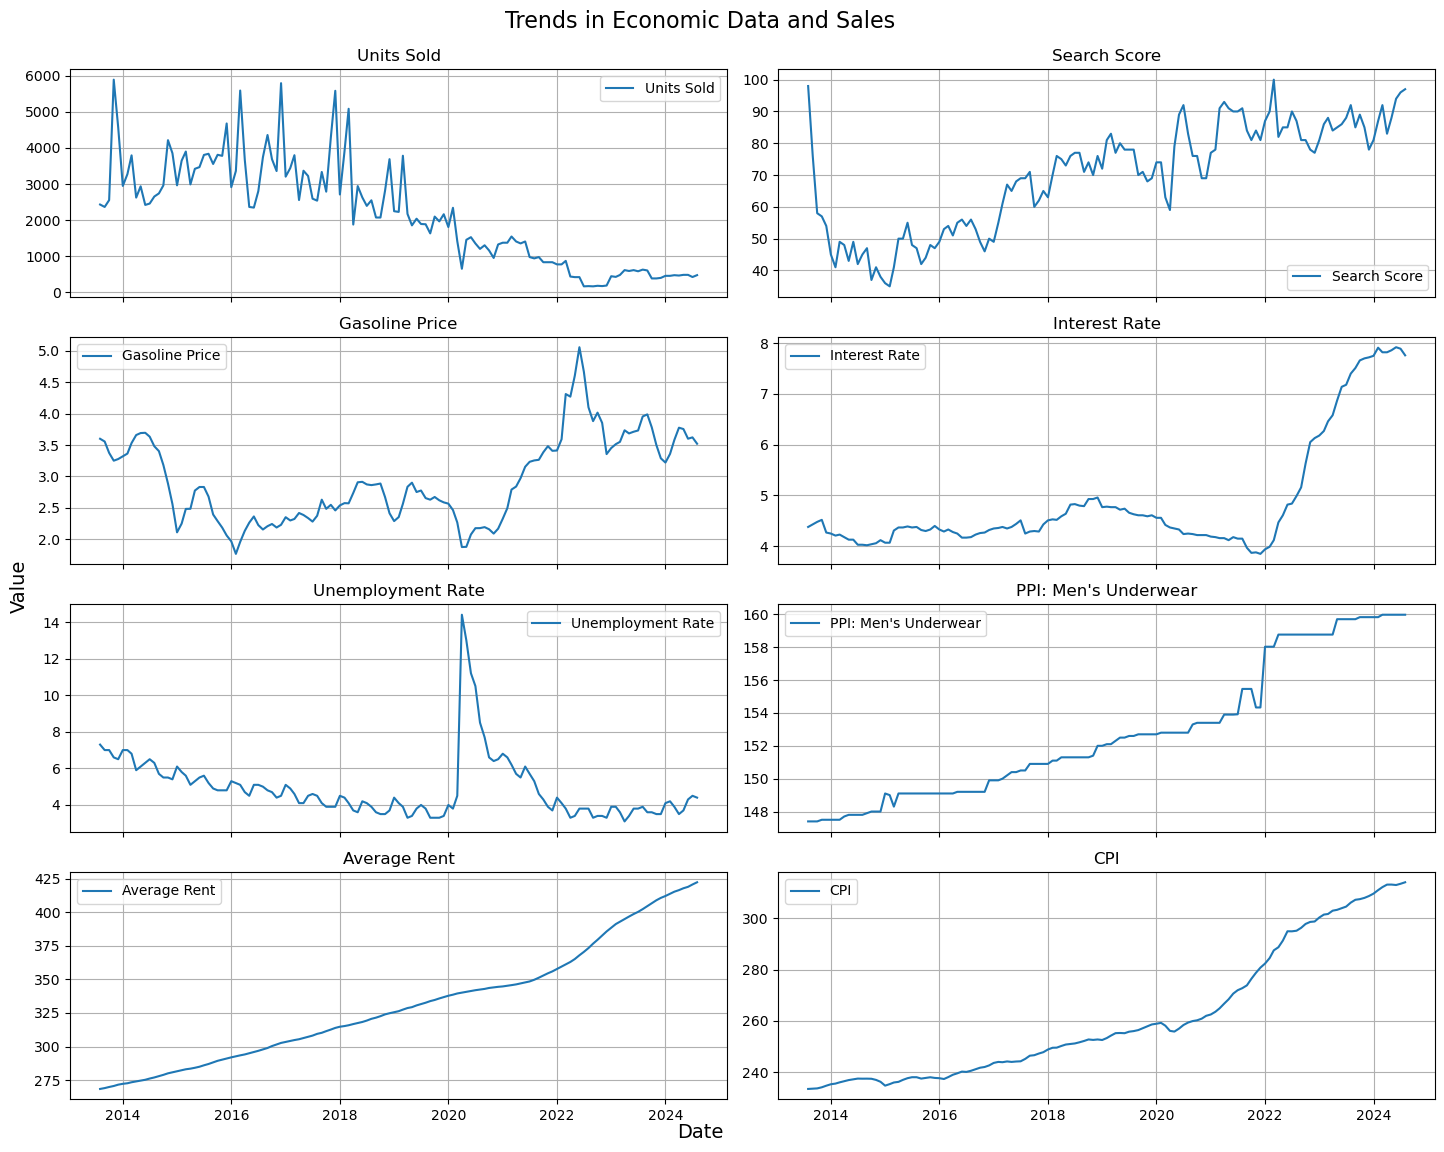

In [43]:
dataframes = [
    q50_sales_df, search_df, gasoline_df, interest_df,
    unemployment_df, mens_df, rent_df, cpi_df
]
names = [
    "Units Sold", "Search Score", "Gasoline Price", "Interest Rate",
    "Unemployment Rate", "PPI: Men's Underwear", "Average Rent", "CPI"
]

fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
axes = axes.flatten()

for i, (df, name) in enumerate(zip(dataframes, names)):
    if name == "Units Sold": 
        x = df["Date"]
        y = df["Units Sold"]
    else:  
        x = dates 
        y = df.iloc[:, 0]

    axes[i].plot(x, y, label=name)
    axes[i].set_title(name, fontsize=12)
    axes[i].grid(True)
    axes[i].legend(fontsize=10)

fig.text(0.5, 0.04, "Date", ha="center", fontsize=14)
fig.text(0.04, 0.5, "Value", va="center", rotation="vertical", fontsize=14)

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.suptitle("Trends in Economic Data and Sales", fontsize=16)
plt.show()

## Prophet Tuning Parameters
Hyperparameter tuning in Prophet is essential for improving model accuracy and fitting, from the Prophet documentation, these are the parameters that
are reccomended to tune

1. **`seasonality_mode`**:
   - Controls whether the seasonality is "additive" or "multiplicative."
   - Importance: Determines how seasonal fluctuations interact with the trend. Multiplicative seasonality is useful when seasonal effects grow proportionally with the trend.

2. **`changepoint_prior_scale`**:
   - Controls how flexible the trend is, affecting how much the model can adapt to changes in the trend.
   - Importance: Helps avoid overfitting or underfitting by adjusting how sensitive the model is to trend changes.

3. **`seasonality_prior_scale`**:
   - Controls the strength of the seasonal component, with larger values allowing more complex seasonal patterns.
   - Importance: Useful for adjusting how much influence the seasonality should have in the model.

![title](assets/seasonality.png)

## Prophet Hyperparameter Tuning

In [46]:
from prophet import Prophet

In [47]:
import itertools

In [48]:
prophet_data = q50_sales_df.rename(columns={"Date": "ds", "Units Sold": "y"})
train_data = prophet_data[prophet_data["ds"] < "2024-01-01"]
test_data = prophet_data[(prophet_data["ds"] >= "2024-01-01") & (prophet_data["ds"] <= "2024-06-01")]

# Grid of parameter values
param_grid = {
    "seasonality_mode": ["additive", "multiplicative"],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Combinations of these values we will iterate through
all_params = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]

results = []

# Fitting model and making predictions for each to generate MAPE
for params in all_params:
    model = Prophet(
        seasonality_mode=params["seasonality_mode"],
        seasonality_prior_scale=params["seasonality_prior_scale"],
        changepoint_prior_scale=params["changepoint_prior_scale"],
    )
    model.fit(train_data)
    future = model.make_future_dataframe(periods= 6, freq= "MS")
    forecast = model.predict(future)

    # Calculate MAPE on the test set
    test_forecast = forecast[forecast["ds"].isin(test_data["ds"])] # Forecasted dates corresponding with dates of the test data
    mape = mean_absolute_percentage_error(test_data["y"], test_forecast["yhat"])
    results.append((params, mape))

# Finding best parameter based on lowest MAPE
best_params, best_mape = min(results, key=lambda x: x[1])
print(f"Best Parameters: {best_params}")
print(f"Best MAPE: {best_mape}")

17:24:46 - cmdstanpy - INFO - Chain [1] start processing
17:24:46 - cmdstanpy - INFO - Chain [1] done processing
17:24:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:24:46 - cmdstanpy - INFO - Chain [1] start processing
17:24:46 - cmdstanpy - INFO - Chain [1] done processing
17:24:46 - cmdstanpy - INFO - Chain [1] start processing
17:24:47 - cmdstanpy - INFO - Chain [1] done processing
17:24:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:24:47 - cmdstanpy - INFO - Chain [1] start processing
17:24:47 - cmdstanpy - INFO - Chain [1] done processing
17:24:47 - cmdstanpy - INFO - Chain [1] start processing
17:24:47 - cmdstanpy - INFO - Chain [1] done processing
17:24:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Best Parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
Best MAPE: 0.1690782699094708


## Prophet with new Hyperparameters
Now that we have the proper hyperparameters, we can fit the model

In [50]:
# Fitting model with the parameters that we just chose
model_simple = Prophet(seasonality_mode="multiplicative", changepoint_prior_scale = 0.01, seasonality_prior_scale = 0.01)

# Columns named df and y as described in documenation
prophet_data = q50_sales_df.rename(columns={"Date": "ds", "Units Sold": "y"})

# Train with pre 2024 data as we did with the previous ML approaches
train_data = prophet_data[prophet_data["ds"] < "2024-01-01"]
model_simple.fit(train_data)

# Forecasting the first six months of 2024
future_simple = model_simple.make_future_dataframe(periods=6, freq="MS")
forecast_simple = model_simple.predict(future_simple)

# Now create tables with the actual and forecasted data so that we can gauge accuracy later
actuals_2024 = prophet_data[prophet_data["ds"] >= "2024-01-01"]
predictions_2024 = forecast_simple[forecast_simple["ds"] >= "2024-01-01"]
actuals_2024 = actuals_2024[:6] # Sliced this because the actual prediction data goes all the way to august
predictions_2024[["ds", "yhat"]], actuals_2024[["ds", "y"]]

17:24:57 - cmdstanpy - INFO - Chain [1] start processing
17:24:57 - cmdstanpy - INFO - Chain [1] done processing


(            ds        yhat
 125 2024-01-01  453.737119
 126 2024-02-01  434.898078
 127 2024-03-01  424.574263
 128 2024-04-01  371.674386
 129 2024-05-01  348.755085
 130 2024-06-01  319.071921,
             ds    y
 125 2024-01-01  460
 126 2024-02-01  460
 127 2024-03-01  478
 128 2024-04-01  468
 129 2024-05-01  487
 130 2024-06-01  487)

In [51]:
# Aggregate table with both y, yhat and date
prophet_result_df = actuals_2024[["ds", "y"]].reset_index(drop=True)
prophet_result_df["yhat"] = predictions_2024["yhat"].values

# Gague model performance on held out test data
mape = mean_absolute_percentage_error(actuals_2024["y"], predictions_2024["yhat"])
rmse = mean_squared_error(actuals_2024["y"], predictions_2024["yhat"], squared=False)
print("MAPE:", mape)
print("RMSE:", rmse)
print("\nProphet Results DataFrame:")

prophet_result_df

MAPE: 0.1690782699094708
RMSE: 100.09475478977883

Prophet Results DataFrame:


,ds,y,yhat
0,2024-01-01,460,453.737119
1,2024-02-01,460,434.898078
2,2024-03-01,478,424.574263
3,2024-04-01,468,371.674386
4,2024-05-01,487,348.755085
5,2024-06-01,487,319.071921


## Visualizing All Results

In [53]:
# Now we aggregate all data from the previous ML approaches with this for easy plotting
results_df["Prophet"] = pd.to_numeric(prophet_result_df["yhat"][:6].values)
results_df

,ds,Actual,Lasso,Random Forest,XGBoost,Prophet
120,2024-01-01,460,237.525791,373.64,416.469330,453.737119
121,2024-02-01,460,268.972379,434.32,409.489716,434.898078
122,2024-03-01,478,352.728048,486.71,420.990967,424.574263
123,2024-04-01,468,468.138898,515.69,535.731140,371.674386
124,2024-05-01,487,558.612112,570.82,601.937256,348.755085
125,2024-06-01,487,462.873414,567.53,619.684326,319.071921


In [54]:
results_list = []

# Loop through each model and calculate metrics as done before for the other table
for model_name, y_pred in zip(
    ["Lasso", "Random Forest", "XGBoost"], 
    [final_y_pred, y_pred_rf, y_pred_xgb]
):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results_list.append({"Model Name": model_name, "RMSE": rmse, "MAPE": mape})

# Add Prophet results
prophet_mape = mean_absolute_percentage_error(actuals_2024["y"], predictions_2024["yhat"])
prophet_rmse = mean_squared_error(actuals_2024["y"], predictions_2024["yhat"], squared=False)
results_list.append({"Model Name": "Prophet", "RMSE": prophet_rmse, "MAPE": prophet_mape})
metrics_final_df = pd.DataFrame(results_list)
print("Final Aggregate Results:")
metrics_final_df

Final Aggregate Results:


,Model Name,RMSE,MAPE
0,Lasso,133.784524,0.226313
1,Random Forest,63.217331,0.116861
2,XGBoost,84.754005,0.162815
3,Prophet,100.094755,0.169078


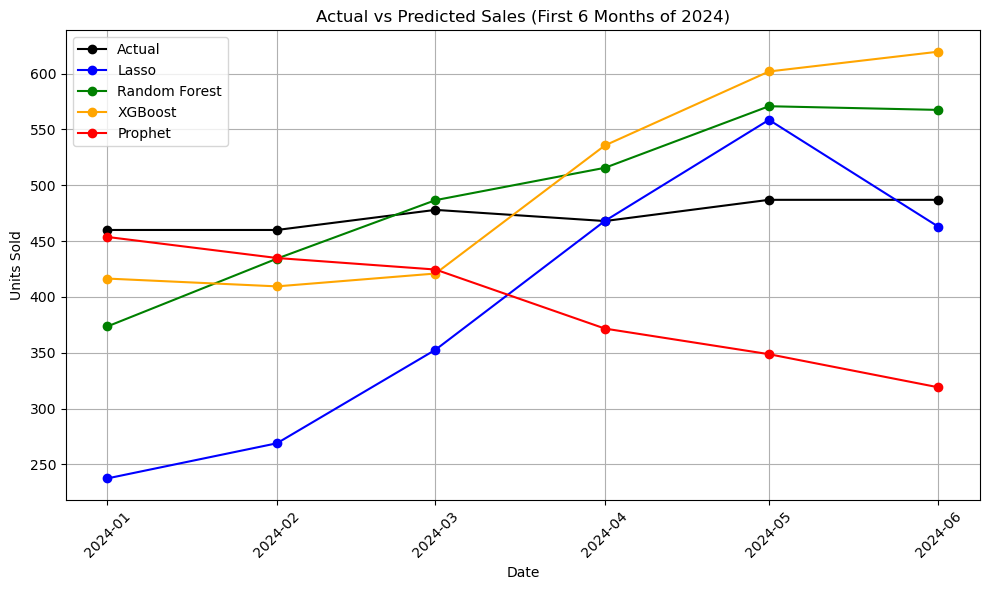

In [55]:
plt.figure(figsize=(10, 6))

plt.plot(results_df["ds"], results_df["Actual"], label="Actual", marker="o", color="black")

plt.plot(results_df["ds"], results_df["Lasso"], label="Lasso", marker="o", color="blue")
plt.plot(results_df["ds"], results_df["Random Forest"], label="Random Forest", marker="o", color="green")
plt.plot(results_df["ds"], results_df["XGBoost"], label="XGBoost", marker="o", color="orange")
plt.plot(results_df["ds"], results_df["Prophet"], label="Prophet", marker="o", color="red")

plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title("Actual vs Predicted Sales (First 6 Months of 2024)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()